In [1]:
import os
import time
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F

from torchvision import models
from torchvision import datasets, transforms

In [2]:
# Check if GPU is available
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:3


In [3]:
cifar_train = datasets.CIFAR10('./data', train=True, download=True ,transform=transforms.ToTensor())
cifar_test = datasets.CIFAR10('./data', train=False, download=True ,transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Function to subsample CIFAR-10 dataset
def subsample_dataset(dataset, sample_size=1000):
    indices = np.random.choice(len(dataset), sample_size, replace=False)
    subset = Subset(dataset, indices)
    return subset

# Subsample the training and test datasets
sample_size = 1000
train_subset = subsample_dataset(cifar_train, sample_size=sample_size)
test_subset = subsample_dataset(cifar_test, sample_size=int(sample_size * 0.2))

# Load data into PyTorch DataLoader
train_loader = DataLoader(train_subset, batch_size=sample_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=int(sample_size * 0.2), shuffle=False)

# Fetch all data and labels for easier handling
X_train, y_train = next(iter(train_loader))
X_test, y_test = next(iter(test_loader))

print("Before Flattening")
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# Reshape the images to 2D tensors and move to device
X_train = X_train.view(X_train.size(0), -1).to(device)  # Flatten
X_test = X_test.view(X_test.size(0), -1).to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

print("After Flattening")
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Before Flattening
Training data shape: torch.Size([1000, 3, 32, 32])
Test data shape: torch.Size([200, 3, 32, 32])
After Flattening
Training data shape: torch.Size([1000, 3072])
Test data shape: torch.Size([200, 3072])


In [6]:
import numpy as np

class MLPClassifier: #Updated MLP with 2 hidden Layers (Different from Lab which had one Hidden Layer
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        # --- Weight initialization ---
        # Layer 1
        self.W1 = np.random.randn(hidden1_size, input_size) * 0.01
        self.b1 = np.zeros((hidden1_size, 1))

        # Layer 2
        self.W2 = np.random.randn(hidden2_size, hidden1_size) * 0.01
        self.b2 = np.zeros((hidden2_size, 1))

        # Output layer
        self.W3 = np.random.randn(output_size, hidden2_size) * 0.01
        self.b3 = np.zeros((output_size, 1))

    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return (z > 0).astype(float)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)

    def forward(self, X):
        """Forward pass"""

        # Layer 1
        self.Z1 = np.dot(self.W1, X) + self.b1
        self.A1 = self.relu(self.Z1)

        # Layer 2
        self.Z2 = np.dot(self.W2, self.A1) + self.b2
        self.A2 = self.relu(self.Z2)

        # Output layer
        self.Z3 = np.dot(self.W3, self.A2) + self.b3
        self.A3 = self.softmax(self.Z3)

        return self.A3

    def compute_loss(self, A3, y):
        """Cross entropy loss"""
        m = y.shape[0]
        log_likelihood = -np.log(A3[y, range(m)])
        return np.sum(log_likelihood) / m

    def backward(self, X, y, learning_rate=0.01):
        """Backward pass with two hidden layers"""
        
        m = X.shape[1]

        # Output layer gradient
        dZ3 = self.A3
        dZ3[y, range(m)] -= 1
        dZ3 /= m

        dW3 = np.dot(dZ3, self.A2.T)
        db3 = np.sum(dZ3, axis=1, keepdims=True)

        # Backprop into Hidden Layer 2
        dA2 = np.dot(self.W3.T, dZ3)
        dZ2 = dA2 * self.relu_derivative(self.Z2)

        dW2 = np.dot(dZ2, self.A1.T)
        db2 = np.sum(dZ2, axis=1, keepdims=True)

        # Backprop into Hidden Layer 1
        dA1 = np.dot(self.W2.T, dZ2)
        dZ1 = dA1 * self.relu_derivative(self.Z1)

        dW1 = np.dot(dZ1, X.T)
        db1 = np.sum(dZ1, axis=1, keepdims=True)

        # Update parameters
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1

        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2

        self.W3 -= learning_rate * dW3
        self.b3 -= learning_rate * db3

    def train(self, X_train, y_train, epochs=100, learning_rate=0.01):
        losses = []
        for i in range(epochs):
            A3 = self.forward(X_train)
            loss = self.compute_loss(A3, y_train)
            print(f"Epoch {i+1}, Loss: {loss}")
            losses.append(loss)
            self.backward(X_train, y_train, learning_rate)
        return losses


In [8]:
input_size = 3072           # CIFAR-10 images are 32x32x3
hidden1_size=128
hidden2_size=64
output_size = 10            # 10 classes for CIFAR-10

# Move data to CPU and convert to numpy
X_train_np = X_train.detach().cpu().numpy()
y_train_np = y_train.detach().cpu().numpy()

# Use transposed input since your model expects (input_size, batch_size)
X_train_np = X_train_np.T  # shape (3072, 1000)

# Train
mlp = MLPClassifier(input_size, hidden1_size, hidden2_size, output_size)
losses = mlp.train(X_train_np, y_train_np, epochs=100, learning_rate=0.01)

Epoch 1, Loss: 2.302581756205559
Epoch 2, Loss: 2.3025739248342454
Epoch 3, Loss: 2.302566104397816
Epoch 4, Loss: 2.30255829901463
Epoch 5, Loss: 2.302550511050238
Epoch 6, Loss: 2.302542734897362
Epoch 7, Loss: 2.302534973239505
Epoch 8, Loss: 2.3025272256389626
Epoch 9, Loss: 2.302519490396945
Epoch 10, Loss: 2.302511779307862
Epoch 11, Loss: 2.302504074209305
Epoch 12, Loss: 2.3024963861661982
Epoch 13, Loss: 2.302488708918963
Epoch 14, Loss: 2.3024810500209605
Epoch 15, Loss: 2.3024734021408357
Epoch 16, Loss: 2.3024657746109227
Epoch 17, Loss: 2.3024581716014545
Epoch 18, Loss: 2.30245058626953
Epoch 19, Loss: 2.3024430060280876
Epoch 20, Loss: 2.3024354359960615
Epoch 21, Loss: 2.3024278769221636
Epoch 22, Loss: 2.3024203303686313
Epoch 23, Loss: 2.3024128005674065
Epoch 24, Loss: 2.302405285415262
Epoch 25, Loss: 2.3023977817904235
Epoch 26, Loss: 2.302390293936823
Epoch 27, Loss: 2.3023828069292653
Epoch 28, Loss: 2.3023753355872048
Epoch 29, Loss: 2.302367876557632
Epoch 30, 

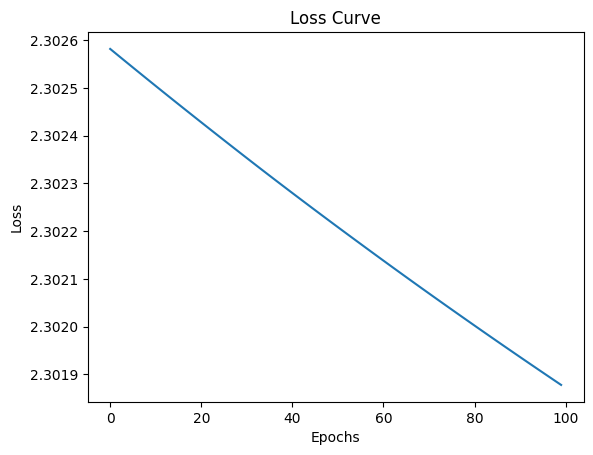

In [9]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()